In [ ]:
#default_exp data.datasets.m4

# M4 dataset

> Download and evaluate the M4 dataset.

The M4 competition extended on the previous three M competitions. The dataset of the contest included 100,000 time series 95,000 of which on yearly, quarterly and monthly frequencies, and the rest in weekly, daily and hourly higher frequencies. This competition received 61 different forecasting methods, notably a neural network model outperformed the rest of the competitors, for the first time in contrast with the previous M forecasting competitions.

[Spyros  Makridakis,  Evangelos  Spiliotis, and  Vassilios Assimakopoulos. The  M4  competition: 100,000  time  series and 61 forecasting methods. International Journal of Forecasting, 36(1):54–74, 2020. ISSN  0169-2070.](https://www.sciencedirect.com/science/article/pii/S0169207019301128)

In [ ]:
#hide
from nbdev import *
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import os
from dataclasses import dataclass
from typing import Optional, Tuple, Union

import numpy as np
import pandas as pd

from neuralforecast.data.datasets.utils import download_file, Info
from neuralforecast.losses.numpy import smape, mase

>M4 meta information

In [ ]:
#export
@dataclass
class Yearly:
    seasonality: int = 1
    horizon: int = 6
    freq: str = 'Y'
    name: str = 'Yearly'
    n_ts: int = 23_000

@dataclass
class Quarterly:
    seasonality: int = 4
    horizon: int = 8
    freq: str = 'Q'
    name: str = 'Quarterly'
    n_ts: int = 24_000

@dataclass
class Monthly:
    seasonality: int = 12
    horizon: int = 18
    freq: str = 'M'
    name: str = 'Monthly'
    n_ts: int = 48_000

@dataclass
class Weekly:
    seasonality: int = 1
    horizon: int = 13
    freq: str = 'W'
    name: str = 'Weekly'
    n_ts: int = 359
        
@dataclass
class Daily:
    seasonality: int = 1
    horizon: int = 14
    freq: str = 'D'
    name: str = 'Daily'
    n_ts: int = 4_227

@dataclass
class Hourly:
    seasonality: int = 24
    horizon: int = 48
    freq: str = 'H'
    name: str = 'Hourly'
    n_ts: int = 414

        
@dataclass
class Other:
    seasonality: int = 1
    horizon: int = 8
    freq: str = 'D'
    name: str = 'Other'
    n_ts: int = 5_000
    included_groups: Tuple = ('Weekly', 'Daily', 'Hourly')

In [ ]:
#export
M4Info = Info(groups=('Yearly', 'Quarterly', 'Monthly', 'Weekly', 'Daily', 'Hourly', 'Other'),
              class_groups=(Yearly, Quarterly, Monthly, Weekly, Daily, Hourly, Other))

## Download data class

In [ ]:
#export
@dataclass
class M4:
    
    source_url: str = 'https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/'
    naive2_forecast_url: str = 'https://github.com/Nixtla/m4-forecasts/raw/master/forecasts/submission-Naive2.zip'

    @staticmethod
    def load(directory: str,
             group: str,
             cache: bool = True) -> Tuple[pd.DataFrame, 
                                          Optional[pd.DataFrame], 
                                          Optional[pd.DataFrame]]:
        """Downloads and loads M4 data.

        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        group: str
            Group name.
            Allowed groups: 'Yearly', 'Quarterly', 'Monthly', 
                            'Weekly', 'Daily', 'Hourly'.
        cache: bool
            If `True` saves and loads 
            
        Returns
        -------
        df: pd.DataFrame
            Target time series with columns ['unique_id', 'ds', 'y'].  
        S_df: pd.DataFrame
            Static exogenous variables with columns ['unique_id', 'ds']. 
            and static variables.       
        """
        path = f'{directory}/m4/datasets'
        file_cache = f'{path}/{group}.p'
        
        if os.path.exists(file_cache) and cache:
            df, X_df, S_df = pd.read_pickle(file_cache)
            
            return df, X_df, S_df
        
        if group == 'Other':
            #Special case.
            included_dfs = [M4.load(directory, gr) \
                            for gr in M4Info['Other'].included_groups]
            df, *_ = zip(*included_dfs)
            df = pd.concat(df)
        else:
            M4.download(directory)
            path = f'{directory}/m4/datasets'
            class_group = M4Info[group]
            S_df = pd.read_csv(f'{directory}/m4/datasets/M4-info.csv', 
                               usecols=['M4id','category'])
            S_df['category'] = S_df['category'].astype('category').cat.codes
            S_df.rename({'M4id': 'unique_id'}, axis=1, inplace=True)
            S_df = S_df[S_df['unique_id'].str.startswith(class_group.name[0])]

            def read_and_melt(file):
                df = pd.read_csv(file)
                df.columns = ['unique_id'] + list(range(1, df.shape[1]))
                df = pd.melt(df, id_vars=['unique_id'], var_name='ds', value_name='y')
                df = df.dropna()

                return df

            df_train = read_and_melt(file=f'{path}/{group}-train.csv')
            df_test = read_and_melt(file=f'{path}/{group}-test.csv')

            len_train = df_train.groupby('unique_id').agg({'ds': 'max'}).reset_index()
            len_train.columns = ['unique_id', 'len_serie']
            df_test = df_test.merge(len_train, on=['unique_id'])
            df_test['ds'] = df_test['ds'] + df_test['len_serie']
            df_test.drop('len_serie', axis=1, inplace=True)

            df = pd.concat([df_train, df_test])
            df = df.sort_values(['unique_id', 'ds']).reset_index(drop=True)
            
            S_df = S_df.sort_values('unique_id').reset_index(drop=True)
        
        X_df = None
        if cache:
            pd.to_pickle((df, X_df, S_df), file_cache)
            
        return df, None, S_df

    @staticmethod
    def download(directory: str) -> None:
        """
        Download M4 Dataset.
        
        Parameters
        ----------
        directory: str
            Directory path to download dataset.
        """
        path = f'{directory}/m4/datasets/'
        if not os.path.exists(path):
            for group in M4Info.groups:
                download_file(path, f'{M4.source_url}/Train/{group}-train.csv')
                download_file(path, f'{M4.source_url}/Test/{group}-test.csv')
            download_file(path, f'{M4.source_url}/M4-info.csv')
            download_file(path, M4.naive2_forecast_url, decompress=True)

In [ ]:
for group, meta in M4Info:
    if group != 'Hourly':
        continue
    df, *_ = M4.load(directory='data', group=group)
    n_series = len(np.unique(df.unique_id.values))

    display_str  = f'Group: {group} '
    display_str += f'n_series: {n_series}'
    print(display_str)

Group: Hourly n_series: 414


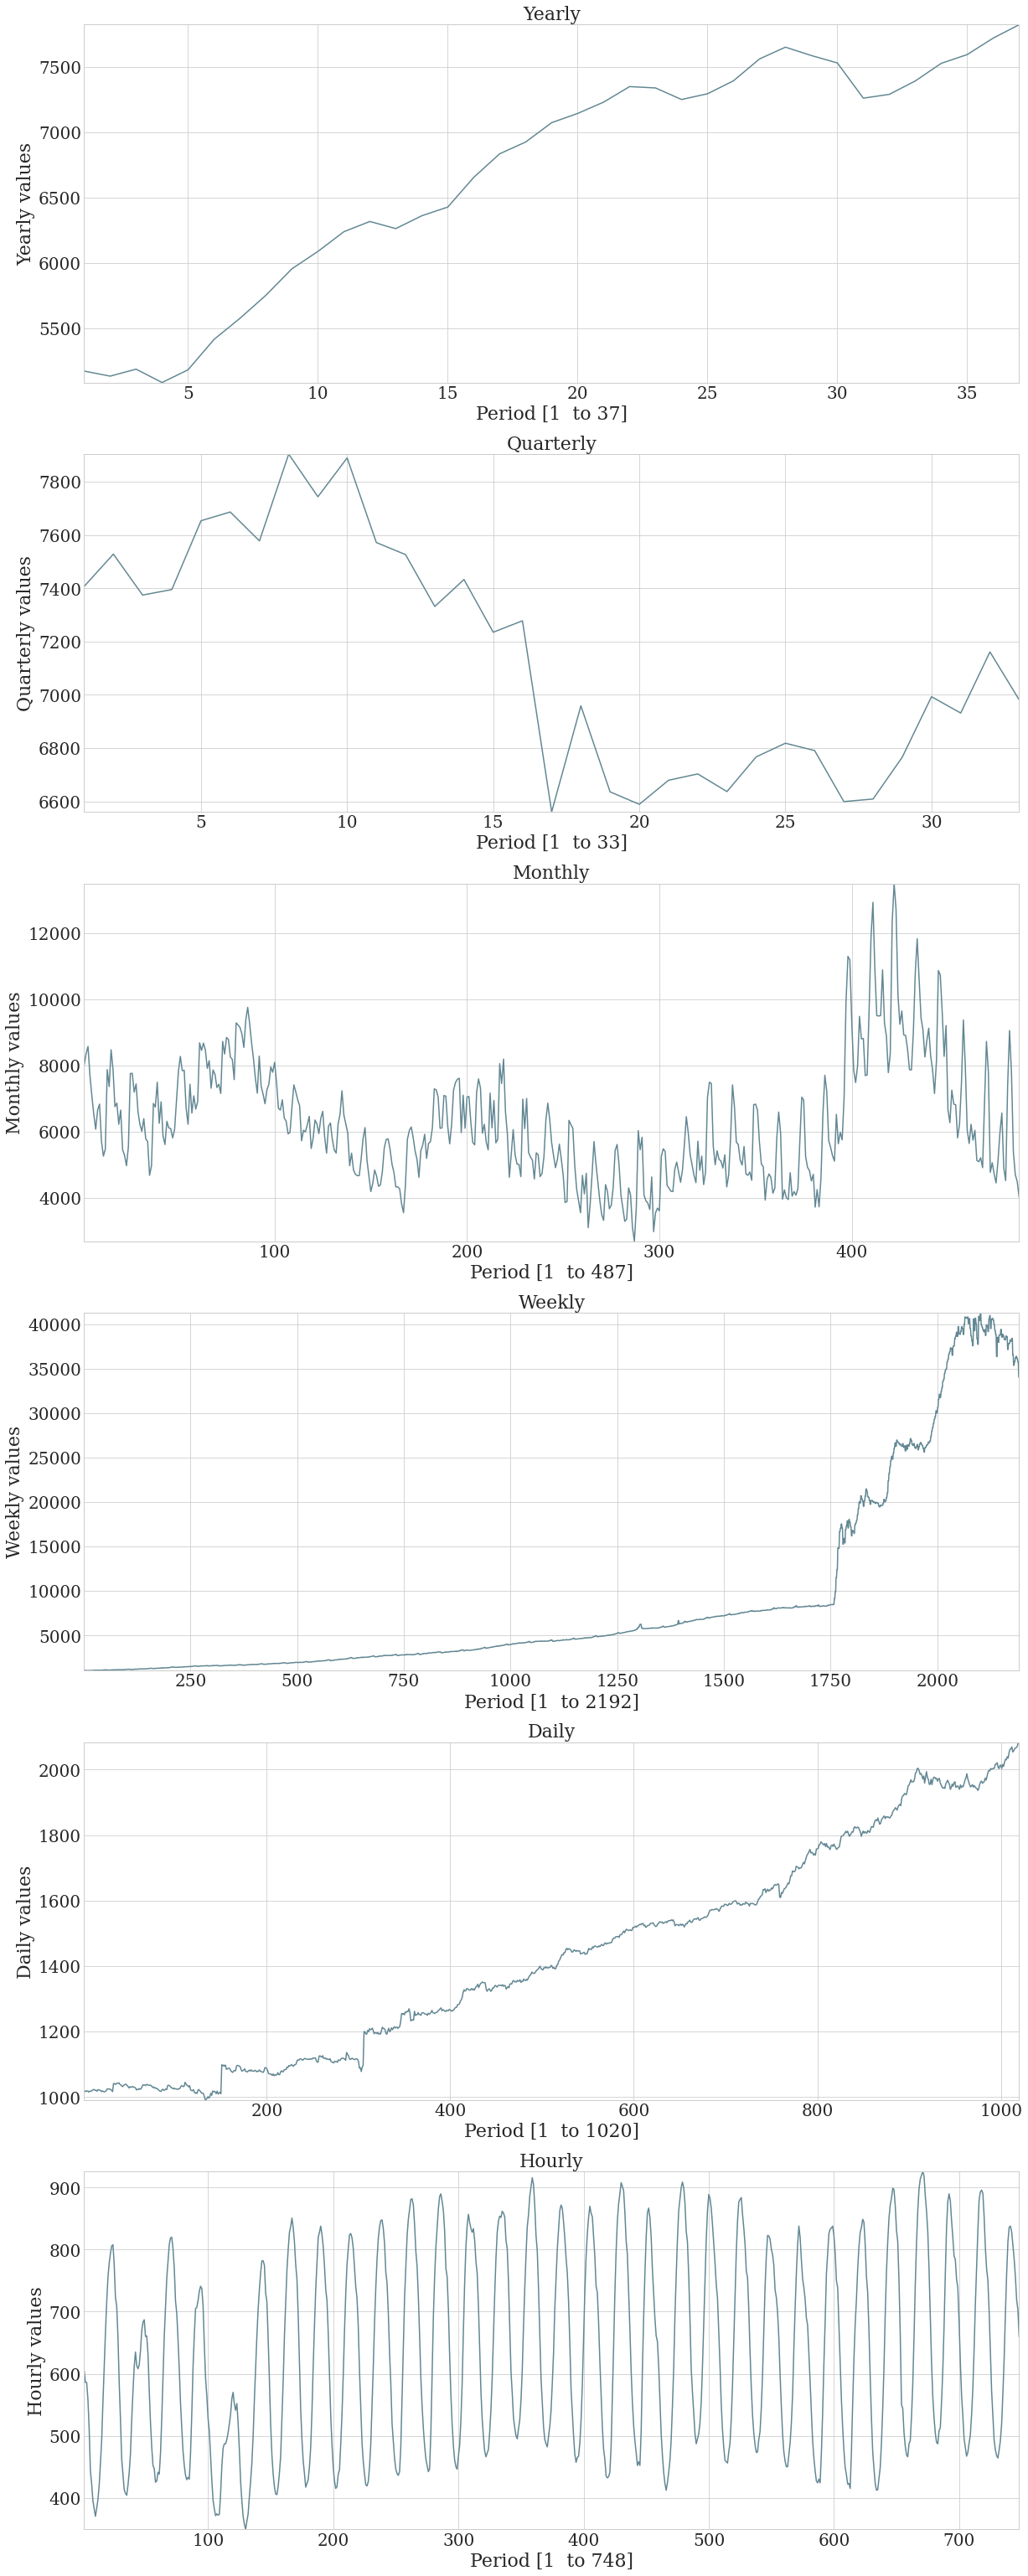

In [ ]:
from neuralforecast.data.datasets.m4 import M4, M4Info
from neuralforecast.data.datasets.plots import draw_plot

import matplotlib.pyplot as plt
import os

if not os.path.exists('./results/'):
    os.makedirs('./results/')

fig = plt.figure(figsize=(20, 55))
fig.tight_layout()
ax0 = plt.subplot2grid((6,1),(0, 0))
ax1 = plt.subplot2grid((6,1),(1, 0))
ax2 = plt.subplot2grid((6,1),(2, 0))
ax3 = plt.subplot2grid((6,1),(3, 0))
ax4 = plt.subplot2grid((6,1),(4, 0))
ax5 = plt.subplot2grid((6,1),(5, 0))
axs = [ax0, ax1, ax2, ax3, ax4, ax5]

dataset = M4Info.groups

for idx, group in enumerate(dataset):
    if group == 'Other':
        continue

    Y_df, _, _ = M4.load(directory='data', group=group)

    x_plot = Y_df[Y_df.unique_id==group[0]+str(1)].ds.values 
    y_plot = Y_df[Y_df.unique_id==group[0]+str(1)].y.values 

    title_str = group
    x_axis_str = f'Period [{str(x_plot.min())[:10]}  to {str(x_plot.max())[:10]}]'
    y_axis_str = group + f' values'

    draw_plot(x_plot, y_plot, title_str, x_axis_str, y_axis_str, axs[idx])

plt.savefig('./results/m4.pdf', bbox_inches = 'tight')
plt.show()

## Evaluation class

In [ ]:
#export
class M4Evaluation:
    
    @staticmethod
    def load_benchmark(directory: str, group: str,
                       source_url: Optional[str] = None) -> np.ndarray:
        """Downloads and loads a bechmark forecasts.
        
        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        group: str
            Group name.
            Allowed groups: 'Yearly', 'Quarterly', 'Monthly', 
                            'Weekly', 'Daily', 'Hourly'.
        source_url: str, optional
            Optional benchmark url obtained from 
            https://github.com/Nixtla/m4-forecasts/tree/master/forecasts.
            If `None` returns Naive2. 
        
        Returns
        -------
        benchmark: numpy array
            Numpy array of shape (n_series, horizon).
        """
        path = f'{directory}/m4/datasets'
        initial = group[0]
        if source_url is not None:
            filename = source_url.split('/')[-1].replace('.rar', '.csv')
            filepath = f'{path}/{filename}'
            if not os.path.exists(filepath):
                download_file(path, source_url, decompress=True)
            
        else:
            filepath = f'{path}/submission-Naive2.csv'
        
        benchmark = pd.read_csv(filepath)
        benchmark = benchmark[benchmark['id'].str.startswith(initial)]
        benchmark = benchmark.set_index('id').dropna(1)
        benchmark = benchmark.sort_values('id').values
        
        return benchmark
    
    @staticmethod
    def evaluate(directory: str, group: str, 
                 y_hat: Union[np.ndarray, str]) -> pd.DataFrame:
        """Evaluates y_hat according to M4 methodology.
        
        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        group: str
            Group name.
            Allowed groups: 'Yearly', 'Quarterly', 'Monthly', 
                            'Weekly', 'Daily', 'Hourly'.
        y_hat: numpy array, str
            Group forecasts as numpy array or
            benchmark url from
            https://github.com/Nixtla/m4-forecasts/tree/master/forecasts.
            
        Returns
        -------
        evaluation: pandas dataframe
            DataFrame with columns OWA, SMAPE, MASE
            and group as index.
        """
        if isinstance(y_hat, str):
            y_hat = M4Evaluation.load_benchmark(directory, group, y_hat)
        
        initial = group[0]
        class_group = M4Info[group]
        horizon = class_group.horizon
        seasonality = class_group.seasonality
        path = f'{directory}/m4/datasets'
        y_df, *_ = M4.load(directory, group)
        
        y_train = y_df.groupby('unique_id')['y'] 
        y_train = y_train.apply(lambda x: x.head(-horizon).values)
        y_train = y_train.values
        
        y_test = y_df.groupby('unique_id')['y']
        y_test = y_test.tail(horizon)
        y_test = y_test.values.reshape(-1, horizon)    

        naive2 = M4Evaluation.load_benchmark(directory, group)
        smape_y_hat = smape(y_test, y_hat)
        smape_naive2 = smape(y_test, naive2)
        
        mase_y_hat = np.mean([mase(y_test[i], y_hat[i], y_train[i], seasonality)
                              for i in range(class_group.n_ts)])
        mase_naive2 = np.mean([mase(y_test[i], naive2[i], y_train[i], seasonality)
                               for i in range(class_group.n_ts)])
        
        owa = .5 * (mase_y_hat / mase_naive2 + smape_y_hat / smape_naive2)
        
        evaluation = pd.DataFrame({'SMAPE': smape_y_hat,
                                   'MASE': mase_y_hat,
                                   'OWA': owa},
                                   index=[group])
        
        return evaluation

### URL-based evaluation

The method `evaluate` from the class `M4Evaluation` can receive a url of a [benchmark uploaded to the M4 competiton](https://github.com/Mcompetitions/M4-methods/tree/master/Point%20Forecasts).  

The results compared to the on-the-fly evaluation were obtained from the [official evaluation](https://github.com/Mcompetitions/M4-methods/blob/master/Evaluation%20and%20Ranks.xlsx).

In [ ]:
esrnn_url = 'https://github.com/Nixtla/m4-forecasts/raw/master/forecasts/submission-118.zip'
esrnn_evaluation = M4Evaluation.evaluate('data', 'Hourly', esrnn_url)
# Test of the same evaluation as the original one
test_close(esrnn_evaluation['SMAPE'].item(), 9.328, eps=1e-3)
test_close(esrnn_evaluation['MASE'].item(), 0.893, eps=1e-3)
test_close(esrnn_evaluation['OWA'].item(), 0.440, eps=1e-3)
esrnn_evaluation

,SMAPE,MASE,OWA
Hourly,9.328443,0.893046,0.440163


### Numpy-based evaluation

Also the method `evaluate` can recevie a numpy array of forecasts.  

In [ ]:
fforma_url = 'https://github.com/Nixtla/m4-forecasts/raw/master/forecasts/submission-245.zip'
fforma_forecasts = M4Evaluation.load_benchmark('data', 'Hourly', fforma_url)
fforma_evaluation = M4Evaluation.evaluate('data', 'Hourly', fforma_forecasts)
# Test of the same evaluation as the original one
test_close(fforma_evaluation['SMAPE'].item(), 11.506, eps=1e-3)
test_close(fforma_evaluation['MASE'].item(), 0.819, eps=1e-3)
test_close(fforma_evaluation['OWA'].item(), 0.484, eps=1e-3)
fforma_evaluation

,SMAPE,MASE,OWA
Hourly,11.505702,0.818598,0.483841
